<a href="https://colab.research.google.com/github/axstiz/AD_practices/blob/master/qq/Homeworks/RAG/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain-gigachat langchain-chroma python-dotenv langchain langchain-community langchain-core

INFO: pip is looking at multiple versions of langchain-chroma to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of langchain to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to buil

In [2]:
import os
from google.colab import userdata
from langchain_gigachat.chat_models import GigaChat

In [3]:
auth = userdata.get('SBER_AUTH')

llm = GigaChat(credentials = auth, verify_ssl_certs = False)

In [4]:
from langchain.schema import HumanMessage

question = "Ответь кратко. Какой плащ был у Понтия Пилата?"
llm([HumanMessage(content=question)]).content[0:200]

/tmp/ipython-input-558270807.py:4: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  llm([HumanMessage(content=question)]).content[0:200]


ResponseError: (URL('https://gigachat.devices.sberbank.ru/api/v1/chat/completions'), 402, b'{"status":402,"message":"Payment Required"}\n', Headers({'server': 'SynGX', 'date': 'Wed, 24 Dec 2025 10:11:26 GMT', 'content-type': 'application/json; charset=utf-8', 'content-length': '44', 'connection': 'keep-alive', 'access-control-allow-credentials': 'true', 'access-control-allow-headers': 'Origin, X-Requested-With, Content-Type, Accept, Authorization', 'access-control-allow-methods': 'GET, POST, DELETE, OPTIONS', 'access-control-allow-origin': 'https://beta.saluteai.sberdevices.ru', 'x-request-id': 'e5206e35-48c9-4406-a42f-f264f1d5bdd0', 'x-session-id': '4242bdd6-c2fb-4e5c-b272-9ebeffc118e0', 'allow': 'GET, POST', 'strict-transport-security': 'max-age=31536000; includeSubDomains'}))

In [ ]:
from langchain.document_loaders import TextLoader
#from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
)

In [ ]:
loader = TextLoader("./Master_i_Margarita.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
documents = text_splitter.split_documents(documents)
print(f"Total documents: {len(documents)}")

RuntimeError: Error loading ./Master_i_Margarita.txt

chunck_overlap

In [ ]:
from chromadb.config import Settings
from langchain_gigachat.embeddings.gigachat import GigaChatEmbeddings
from langchain_chroma import Chroma

embeddings = GigaChatEmbeddings(
    credentials = auth, verify_ssl_certs=False
)

db = Chroma.from_documents(
    documents,
    embeddings,
    client_settings=Settings(anonymized_telemetry=False),
)

GigaChatEmbeddings — это класс из фреймворка GigaChain (разработанного Сбером), который позволяет получать векторные представления (эмбеддинги) текстов с помощью языковой модели GigaChat через её API.

Это официальный способ генерировать семантические эмбеддинги для русскоязычных (и мультиязычных) текстов в экосистеме GigaChat.



Chroma — это лёгкая, open-source векторная база данных, специально разработанная для AI-приложений, включая RAG.
Она позволяет:

* хранить эмбеддинги (векторные представления текста),
* выполнять семантический поиск по схожести,
* интегрироваться с LangChain, LlamaIndex, GigaChain и другими фреймворкам

В GigaChain Chroma используется как векторный стор (vector store) для хранения и поиска документов.

Найдем, что больше подходит к запросу

In [ ]:
question = "Какой плащ был у Понтия Пилата?"
docs = db.similarity_search(question, k=4)
len(docs)

In [ ]:
print(f"... {str(docs[1])} ...")

In [ ]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(llm, retriever=db.as_retriever())

RetrievalQA — это тип цепочки (chain) в фреймворках для работы с большими языковыми моделями (LLM), таких как LangChain и GigaChain, который реализует паттерн RAG (Retrieval-Augmented Generation).

Он автоматизирует процесс:

Поиска релевантной информации в базе знаний (векторном хранилище),
Генерации ответа на основе найденного контекста с помощью LLM.

В GigaChain (фреймворке от Сбера для работы с GigaChat и RAG-приложениями) концепция, аналогичная классической RetrievalQA из LangChain, реализована через цепочки (chains), которые объединяют:

* LLM (например, GigaChat),

* векторное хранилище (например, Chroma),

* стратегию извлечения и генерации (RAG).

Хотя в GigaChain нет класса с точным названием RetrievalQA, его функциональность легко воспроизводится с помощью встроенных компонентов.

В запрос LLMке подаётся дополнительный контекст из документа!!!
**Запрос обогащается контекстом документа**

In [ ]:
qa_chain({"query": question})

In [ ]:
qa_chain({"query": "Какая трость была у Воланда?"})

In [ ]:
qa_chain({"query": "что не смогли купить герои романа на Патриарших?"})

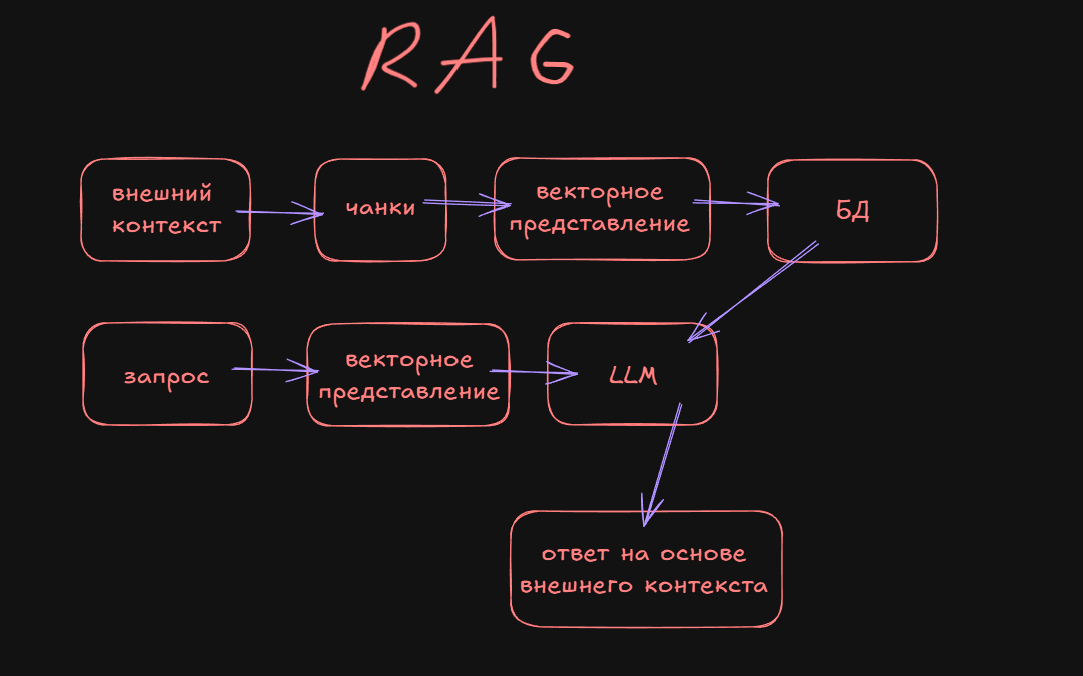

**RAG (Retrieval-Augmented Generation)** — это архитектура для генерации текста с использованием **внешних источников знаний**. Она сочетает в себе:

1. **Поиск (Retrieval)** — извлечение релевантной информации из базы данных,  
2. **Генерацию (Generation)** — создание ответа на основе этой информации с помощью языковой модели (LLM).

Это позволяет LLM **отвечать точнее**, **опираться на актуальные или специфические данные** и **не "галлюцинировать"**, когда у неё нет нужной информации.

---

## 🔧 Как работает RAG — пошагово

### Шаг 1. **Подготовка знаний (ингестия)**
- Документы (тексты, PDF, веб-страницы и т.д.) разбиваются на **фрагменты** (chunks).
- Для каждого фрагмента создаётся **векторное представление (эмбеддинг)** с помощью модели эмбеддингов.
- Все эмбеддинги сохраняются в **векторной базе данных** (например, Chroma, FAISS, Qdrant).

> 📌 Пример:  
> Фрагмент: *«GigaChat — это LLM от Сбера, запущенная в 2023 году.»*  
> → Эмбеддинг: `[0.23, -0.45, ..., 0.89]` (вектор длиной 1024 и т.п.)

---

### Шаг 2. **Получение запроса от пользователя**
Пользователь задаёт вопрос, например:  
> *«Когда был запущен GigaChat?»*

---

### Шаг 3. **Retrieval — поиск релевантных фрагментов**
- Запрос пользователя тоже преобразуется в **эмбеддинг**.
- Система ищет в векторной БД **k самых близких по смыслу фрагментов** (через cosine similarity и т.п.).
- Например, найдёт фрагмент: *«GigaChat — это LLM от Сбера, запущенная в 2023 году.»*

---

### Шаг 4. **Augmentation — формирование контекста**
Найденные фрагменты вставляются в **промпт** для языковой модели:

```text
Используй только следующую информацию для ответа.

Контекст:
GigaChat — это LLM от Сбера, запущенная в 2023 году.

Вопрос:
Когда был запущен GigaChat?

Ответ:
```

---

### Шаг 5. **Generation — генерация ответа**
Языковая модель (например, GigaChat, Llama, GPT) получает этот промпт и **генерирует точный, обоснованный ответ**:

> **Ответ**: GigaChat был запущен в 2023 году.

---

## 🎯 Преимущества RAG

| Преимущество | Описание |
|-------------|--------|
| **Актуальность** | Можно обновлять базу знаний без переобучения модели |
| **Точность** | Ответы основаны на реальных данных, а не на памяти LLM |
| **Прозрачность** | Можно показать источники ("цитаты") |
| **Безопасность** | Модель не выдаёт секретную информацию, если она не в базе |
| **Экономия ресурсов** | Не нужно дообучать огромную модель — достаточно обновить документы |

---

## 🧠 Где применяется RAG?

- Корпоративные чат-боты (поддержка по внутренним документам)
- Юридические и медицинские помощники
- Поиск по технической документации
- Персонализированные рекомендации
- Обучение на приватных данных без fine-tuning

---

## 📦 Типичный стек технологий для RAG

| Компонент | Примеры |
|---------|--------|
| **LLM** | GigaChat, Llama 3, GPT-4, Mistral |
| **Эмбеддинги** | GigaChatEmbeddings, `text-embedding-3-small`, `bge-m3` |
| **Векторная БД** | Chroma, FAISS, Qdrant, Milvus, Pinecone |
| **Фреймворк** | LangChain, LlamaIndex, **GigaChain** |

---


## ❗ Ограничения RAG

- Зависит от качества фрагментов и эмбеддингов.
- Может не сработать, если нужная информация **размазана по нескольким фрагментам**.
- Требует хорошей стратегии разбиения текста (`chunk_size`, `overlap`).
- LLM иногда **игнорирует контекст** или **добавляет от себя** (требуется тонкая настройка промпта).

---

## 💡 Советы для эффективного RAG

- Используйте **гидратацию метаданных** (например, указывайте источник, дату).
- Применяйте **ре-ранкинг** (reranker) после первоначального поиска.
- Для длинных документов — используйте chain_type `map_reduce` или `refine`.
- Всегда **возвращайте source_documents**, чтобы можно было проверить ответ.

---

Если хотите — могу показать **рабочий код RAG на Python** с GigaChat и Chroma (как в вашем предыдущем вопросе), или сравнить RAG с fine-tuning.

#**Работа с PDF документами**

In [ ]:
!pip install pypdf langchain-chroma --quiet

In [ ]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("http://www.unn.ru/books/met_files/Alekseev.pdf")

docs = loader.load()
print(len(docs))

In [ ]:
print(docs[0].page_content[0:100])
print(docs[0].metadata)

In [ ]:
from langchain_gigachat.chat_models import GigaChat
from langchain.schema import HumanMessage

giga = GigaChat(
    credentials=auth,
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200,
)

In [ ]:
from langchain_chroma import Chroma
from langchain_gigachat.embeddings.gigachat import GigaChatEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = GigaChatEmbeddings(
    credentials=auth, verify_ssl_certs=False
)


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
# Векторное представление (хранилище) в базе данных Chroma
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)
# retriever
# Объект поиска из векторного хранилища
# vectorstore.as_retriever()
retriever = vectorstore.as_retriever()

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "Ты должен ответить на вопрос пользователя с использованием данных из книги.\n"
    "Отвечаай коротко, не более 2-3 предложений.\n"
    "Вот части книги контекст для ответа:"
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(giga, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

Оригинал: Теорема 5.7 (об эйлеровом цикле). Эйлеров цикл в связном графе существует тогда и только тогда, когда степени всех вершин этого графа четны.

In [ ]:
q = "О чем говорит теорема об эйлеровом цикле?"
pure = giga([HumanMessage(content=q)]).content
print(f"Pure: {pure}")

rag = rag_chain.invoke({"input": q})["answer"]
print(f"RAG: {rag}")

Оригинал:  Оказывается, присутствие в графе нечетных циклов (т.е. циклов нечетной длины) – единственная причина, по которой граф не является двудольным.

In [ ]:
q = "Короткий ответ: По каким причинам граф не будет двудольным? "
pure = giga([HumanMessage(content=q)]).content
print(f"Pure: {pure}\n")

rag = rag_chain.invoke({"input": q})["answer"]
print(f"RAG: {rag}")

Каркас (применяются также термины остов, остовное дерево) связного графа – это дерево, являющееся подграфом этого графа и содержащего все его вершины.

In [ ]:
q = "Дай определение: что такое каркас?"
pure = giga([HumanMessage(content=q)]).content
print(f"Pure: {pure}\n")

rag = rag_chain.invoke({"input": q})["answer"]
print(f"RAG: {rag}")